# Part 1. The Next AAA Title

In this notebook, our goal is to suggest the next AAA title to the management team. To do this, we will analyze the movie titles along with their 'hit-ness' factor and grouped according to their genres. *(We don't want to suggest a title with 'Shrek' on a drama movie')*.

#### Objectives:

- Determine all the possible genres
- Filter the data for each genre
- Remove stop words in the title
- Perform Tfidf in the Title
- Multiply Tfidf by the total accumulated score
- Generate a wordcloud for the top 10 genres

***
### Identifying The Top Genres 

Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [2]:
df_movies = []
df_genre = []
df_ratings = []

From the <code>title_ratings.tsv</code> dataset, we can load all the <code>averageRating</code> and <code>numVotes</code> for all the movie tag <code>tconst</code>.

In [3]:
iter_ratings = pd.read_csv('title_ratings.tsv', sep='\t', iterator=True, chunksize=10000)
df_ratings = pd.concat([chunk for chunk in iter_ratings])
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1892
1,tt0000002,5.9,252
2,tt0000003,6.5,1682
3,tt0000004,5.7,165
4,tt0000005,6.2,2499


From the <code>title_basics.tsv</code> dataset, load the data in chunks filtering only the rows with <code>titleType</code> of <code>movie</code>.

In [4]:
title_basics_col_list = ["tconst", "titleType", "primaryTitle", "genres"]
iter_movie = pd.read_csv('title_basics.tsv', sep='\t', usecols=title_basics_col_list, iterator=True, na_values = '\\N', chunksize=10000)
df_movies = pd.concat([chunk[chunk['titleType']=="movie"] for chunk in iter_movie])
df_movies.head()

,tconst,titleType,primaryTitle,genres
498,tt0000502,movie,Bohemios,NaN
570,tt0000574,movie,The Story of the Kelly Gang,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,Drama
610,tt0000615,movie,Robbery Under Arms,Drama
625,tt0000630,movie,Hamlet,Drama


Check for empty values, and then remove the rows with empty values since we are analyzing the titles in the genres of the movies.

In [5]:
df_movies.isna().sum()

tconst              0
titleType           0
primaryTitle        0
genres          71576
dtype: int64

In [6]:
df_movies.dropna(inplace = True)
df_movies.head()

,tconst,titleType,primaryTitle,genres
570,tt0000574,movie,The Story of the Kelly Gang,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,Drama
610,tt0000615,movie,Robbery Under Arms,Drama
625,tt0000630,movie,Hamlet,Drama
668,tt0000675,movie,Don Quijote,Drama


Since there are no more empty rows, we can now proceed by counting all the possible genre strings in the <code>genres</code> column of <code>df_movies</code>.

In [7]:
genre_dict = dict()
for genre_per_movie in df_movies["genres"]:
    genre_per_movie = str(genre_per_movie)
    genre_in_movie = genre_per_movie.split(",")
    for genre in genre_in_movie:
        #genre = genre.lower()
        if genre in genre_dict:
            genre_dict[genre] += 1
        else:
            genre_dict[genre] = 1
print(genre_dict)

{'Action': 51449, 'Adventure': 26863, 'Biography': 16284, 'Drama': 220244, 'Fantasy': 14465, 'Comedy': 103916, 'War': 9047, 'Documentary': 114293, 'Crime': 35148, 'Romance': 45068, 'Family': 16885, 'History': 13505, 'Sci-Fi': 13087, 'Thriller': 41713, 'Western': 8035, 'Sport': 6629, 'Mystery': 15907, 'Horror': 34231, 'Music': 11513, 'Animation': 8335, 'Musical': 9931, 'Film-Noir': 772, 'News': 1439, 'Short': 56, 'Adult': 8750, 'Reality-TV': 472, 'Talk-Show': 155, 'Game-Show': 24}


We can focus on the top 10 genres in our data set.

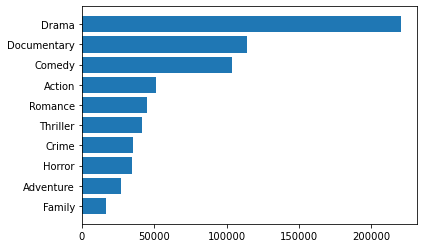

In [8]:
sort_genre_dict = dict(sorted(genre_dict.items(), key=lambda x: x[1], reverse=False))
topN = 10

names = list(sort_genre_dict.keys())[-1*topN:]
values = list(sort_genre_dict.values())[-1*topN:]

plt.barh(range(topN), values, tick_label=names)
plt.show()

### Defining the Helper Functions

In [9]:
### Function to filter the data according to genre_string, and seleting only the movies

def filter_data_by_genre(genre_string):
    title_basics_col_list = ["tconst", "titleType", "primaryTitle", "startYear", "genres"]
    iter_genre = pd.read_csv('title_basics.tsv', sep='\t', usecols=title_basics_col_list, iterator=True, na_values = '\\N', chunksize=10000)
    df_genre = pd.concat([chunk[(chunk["genres"].str.contains(genre_string)) & (chunk['titleType']=="movie")] for chunk in iter_genre])
    df_genre.drop(['titleType'], inplace=True, axis=1)
    df_genre = df_genre.reset_index(drop=True)
    return df_genre

In [10]:
### Since there is a lot of data, we can filter the data to focus our analysis to more relevant variables.
### This means that we can focus on more recent movies, and focus on the top movies based on the accumulated score.

def limit_data(df_genre, df_ratings):

    yearAnalyze = 2000
    topMovies = 2500

    df_genre_rating = pd.merge(df_genre,df_ratings,on='tconst')
    df_genre_rating['totalScore'] = df_genre_rating['averageRating'] * df_genre_rating['numVotes']
    df_genre_rating = df_genre_rating[(df_genre_rating['startYear']>=yearAnalyze)]
    df_genre_rating = df_genre_rating.nlargest(topMovies, 'totalScore')
    #df_genre_rating.head()
    return df_genre_rating

In [11]:
### Function to remove stop words to further narrow down the titles
### Recommendation: include stemming and lemmatization
### Recommendation: remove proper nouns

def remove_stop_words(df_genre_rating):
    df_genre_rating['primaryTitle_new'] = df_genre_rating['primaryTitle'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in (ENGLISH_STOP_WORDS)]))
    df_genre_rating['primaryTitle_new'] = df_genre_rating['primaryTitle_new'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.isnumeric()==False]))
    #df_genre_rating['primaryTitle_new'] = df_genre_rating['primaryTitle_new'].apply(lambda x: ' '.join([w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()]))
    df_genre_rating['primaryTitle_new'] = df_genre_rating['primaryTitle_new'].apply(lambda x: str(x).replace(':',''))
    return df_genre_rating


In [12]:
### Function to get the tfidf dataframe

def tfidf_vectorize(df_genre_rating):
    vec = TfidfVectorizer()
    text_db = list(df_genre_rating['primaryTitle_new'])
    tf_idf = vec.fit_transform(text_db)
    df_tfidf = pd.DataFrame(tf_idf.toarray(), columns = vec.get_feature_names())
    return df_tfidf

In [13]:
### Concatenate the movie title identifier with the tfidf dataframe

def tfidf_merge_index(df_tfidf, df_genre_rating):
    df_index = df_genre_rating[['tconst']]
    df_tfidf.reset_index(drop=True)
    df_tfidf2 = pd.concat([df_index.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)
    df_tfidf2.set_index('tconst', inplace=True)
    #df_tfidf_df2.head()
    return df_tfidf2

In [14]:
### Adjust the tfidf dataframe by multiplying the values with the total accumulated score per movie

def tfidf_weighted(df_tfidf2, df_genre_rating):
    df_weight = list(df_genre_rating['totalScore'])
    df_adjusted_tfidf = df_tfidf2.mul(df_weight, axis=0)
    return df_adjusted_tfidf

In [15]:
### Take the sum of all the scores per word

def get_score_per_word(df_adjusted_tfidf):
    df_sum = pd.DataFrame(df_adjusted_tfidf.sum(axis=0))
    df_sum.reset_index(inplace=True)
    df_sum.columns=['words', 'score']
    df_sum['score'] = df_sum['score']/(df_sum['score'].min())
    #df_sum.head()
    return df_sum

In [16]:
### Define the pipeline of function callouts
### This will return a dataframe of the words with scores per genre

def df_pipeline(genre_string, df_ratings):
    df_genre = filter_data_by_genre(genre_string)
    df_genre_rating = limit_data(df_genre, df_ratings)
    df_genre_rating = remove_stop_words(df_genre_rating)
    df_tfidf = tfidf_vectorize(df_genre_rating)
    df_tfidf2 = tfidf_merge_index(df_tfidf, df_genre_rating)
    df_adjusted_tfidf = tfidf_weighted(df_tfidf2, df_genre_rating)
    df_sum = get_score_per_word(df_adjusted_tfidf)
    df_sum_sorted = df_sum.sort_values(by='score', ascending=False)
    return df_sum_sorted


After defining the helper functions, we can now loop and call the <code>df_pipeline</code> function through the genres obtained in the variable <code>names</code>. Then, we can store the resulting dataframe to a dictionary with the proper genre as the key.

In [17]:
#dict_genre = {'Comedy':df_sum_sorted}
topwords_genre = dict()
genre_list = names
#genre_list = ['Comedy']
for genre_string in genre_list:
    df_sum_sorted = df_pipeline(genre_string, df_ratings)
    topwords_genre[genre_string] = df_sum_sorted

We can check the resulting dataframe for the key <code>Documentary</code>.

In [18]:
topwords_genre['Crime'].head(10)

,words,score
1348,knight,2509.151533
629,dark,2096.151466
207,batman,1656.122550
2321,street,1573.759846
666,departed,1502.978266
939,furious,1451.069625
1272,joker,1384.614848
854,fast,1368.010255
90,american,1335.308451
1719,ocean,1326.309847


### Generating WordCloud

Now that we are successful in scoring the words that are in the title of "hit" movies per genre, we can generate a wordcloud to help in our visualization.

In [19]:
!pip install wordcloud-1.8.1-cp39-cp39-win_amd64.whl

Processing c:\users\pc\portfolio\imdb\wordcloud-1.8.1-cp39-cp39-win_amd64.whl
wordcloud is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [20]:
from wordcloud import WordCloud

In [21]:
### Define function which will generate and save the WordClouds

def generateWordCloud(score_array, genre):
    x=dict()
    for index,pair in score_array.iterrows():
        x[pair.words] = pair.score
    wc = WordCloud(background_color='white', width = 600, height=300, margin=2)
    wc.fit_words(x)
    # Display the generated image:
    
    plt.imshow(wc, interpolation='bilinear')
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    plt.axis("off")
    plt.title(genre)
    plt.savefig(genre+'_wordcloud.png',dpi=100)
    plt.show()

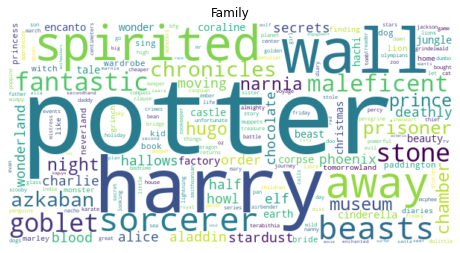

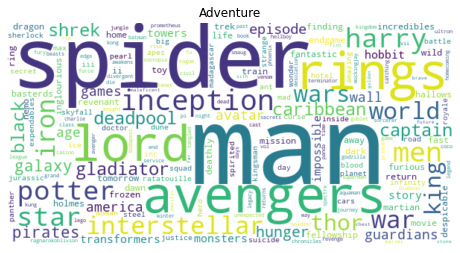

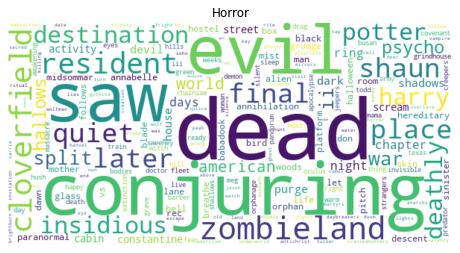

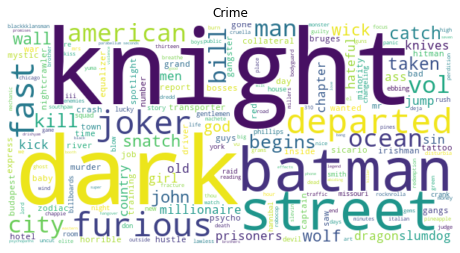

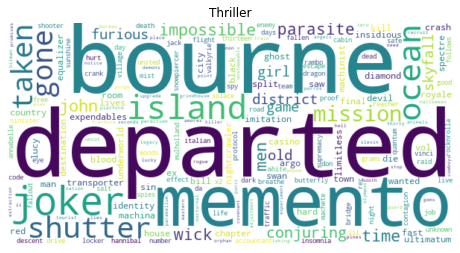

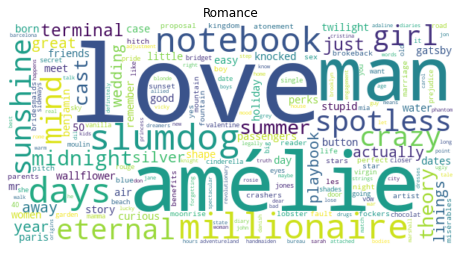

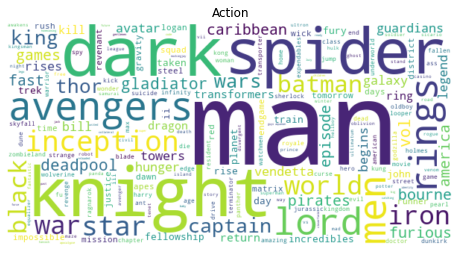

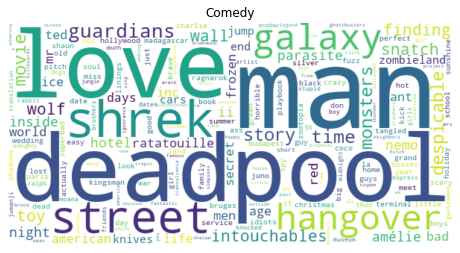

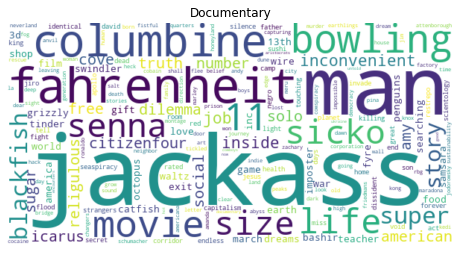

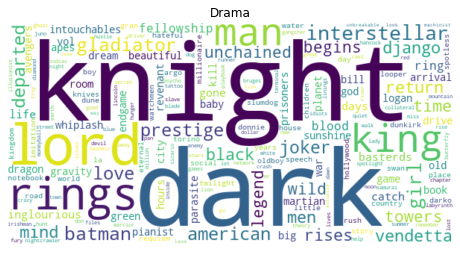

In [22]:
for genre in topwords_genre.keys():
    generateWordCloud(topwords_genre[genre], genre)

### Conclusion

Now that we have wordclouds for different genres, we will be able to conceptualize a title for the next 'hit' movie according to the genre that the management team is targeting.

# Part 2: Movie Title Recommendation

In [23]:
import string
import keras.utils as ku
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from numpy.random import choice

In [36]:
genre_string = 'Comedy'
df_genre = filter_data_by_genre(genre_string)


#title_basics_col_list = ["tconst", "titleType", "primaryTitle", "startYear", "genres"]
##iter_genre = pd.read_csv('title_basics.tsv', sep='\t', usecols=title_basics_col_list, iterator=True, na_values = '\\N', chunksize=10000)
#f_genre = pd.concat([chunk[chunk['titleType']=="movie"] for chunk in iter_genre])
#df_genre.drop(['titleType'], inplace=True, axis=1)
#df_genre = df_genre.reset_index(drop=True)

df_genre_rating = limit_data(df_genre, df_ratings)
df_genre_rating = remove_stop_words(df_genre_rating)

In [37]:
title_list = df_genre_rating['primaryTitle_new'].copy()
title_list

40382              wolf wall street
51749              guardians galaxy
41209                              
30007                  finding nemo
46603                      deadpool
                    ...            
38272                  space chimps
41032    estomago gastronomic story
35061                winter passing
50939                   hatchet iii
35593                    fat albert
Name: primaryTitle_new, Length: 2500, dtype: object

In [38]:
def clean_text(text):
    text = ''.join(e for e in text if e not in string.punctuation).lower()
    
    text = text.encode('utf8').decode('ascii', 'ignore')
    return text


wordlist = list(title_list)
corpus = [clean_text(word) for word in wordlist]

In [39]:
tokenizer = Tokenizer()
def get_sequence_of_tokens(corpus):
    #get tokens
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
 
    #convert to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
 
    return input_sequences, total_words
inp_sequences, total_words = get_sequence_of_tokens(corpus)

In [40]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,  maxlen=max_sequence_len, padding='pre'))
    predictors, label = input_sequences[:,:-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes = total_words)
    return predictors, label, max_sequence_len
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [41]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
 
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
 
    # Add Hidden Layer 1 — LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
 
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
 
    return model
model = create_model(max_sequence_len, total_words)
model.fit(predictors, label, epochs=20, verbose=5)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [42]:
def generate_text(seed_text, next_words, model, max_sequence_len, wordref):
    signal = 0
    while signal == 0:
        seed_text = choice(words)
        for _ in range(next_words):
            signal = 0
            token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1,  padding='pre')
        
            #print(type(token_list))
            #predicted = model.predict(token_list, verbose=0)
            predicted=model.predict(token_list) 
            classes=np.argmax(predicted[0])
 
            output_word = ""
            for word,index in tokenizer.word_index.items():
                #print(index in classes)
                if index == classes:
                    output_word = word
                    if (word in wordref):
                        signal = 1
                    break
                
        
            seed_text += " "+output_word
        if signal == 1:
            break
    return seed_text.title()

In [43]:
completestring = ' '.join([str(''.join([str(word) for word in item])) for item in corpus])
words = completestring.split()
wordref = list(topwords_genre[genre_string].words[0:10])

In [46]:
wordref

['man',
 'deadpool',
 'love',
 'shrek',
 'street',
 'galaxy',
 'hangover',
 'guardians',
 'time',
 'story']

In [44]:
print(generate_text(words, 3, model, max_sequence_len, wordref))

1/1 [==============================] - 0s 29ms/step
Wheres Secret Turtles Story


An attempt to create a model was made such that the model generates words from the movie titles. The loop will go indefinitely until a word in the generated title exists in the top 10 words of the chosen category. In this case, the category chosen is <code>Comedy</code>. Upon running the function, the loop terminates since it found the word "Story" which is among the top 10 words of the Comedy genre.